In [167]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde, variation, pearsonr, spearmanr
from sklearn.metrics import mutual_info_score, roc_curve, auc
from scipy.spatial.distance import mahalanobis, euclidean, cosine, cityblock, chebyshev,jensenshannon
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from tqdm import tqdm
import matplotlib.path as mpath
import sys
import platform
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from PIL import Image



def generate_clinical_manifest(healthy_amount, cancer_amount, healthy_noise, noise_ratio, data_type):
    """
    Generate synthetic datasets for healthy and cancer groups based on different patterns (linear, exponential, etc.).
    
    Inputs:
    - healthy_amount (int): Number of healthy samples.
    - cancer_amount (int): Number of cancer samples.
    - healthy_noise (float): Noise level for healthy samples.
    - noise_ratio (float): Factor by which cancer noise exceeds healthy noise.
    - data_type (str): Pattern type ('linear', 'exp', 'u', 'multicluster').

    Outputs:
    - DataFrame: A DataFrame containing generated OGA, OGT values, and Health_Status labels.
    """
    # Calculate cancer noise based on the noise ratio
    cancer_noise = healthy_noise * noise_ratio

    # Function to generate linear data
    def generate_linear_data(slope, intercept, num_points, label, noise_level):
        # Generate OGA and OGT data points with noise
        oga = np.random.normal(0.5, 0.2, num_points)  # Centered around 0.5
        ogt = slope * oga + intercept + np.random.normal(0, noise_level, num_points)
        return pd.DataFrame({'OGT': np.clip(ogt, 0, None), 'OGA': oga, 'Health_Status': label})

    # Function to generate exponential data
    def generate_exponential_data(base, num_points, label, noise_level):
        # Generate OGA and OGT values following an exponential curve
        oga = np.random.normal(0.5, 0.2, num_points)
        ogt = np.exp(base * (oga - 0.5)) + np.random.normal(0, noise_level, num_points)
        return pd.DataFrame({'OGT': np.clip(ogt, 0, 10), 'OGA': oga, 'Health_Status': label})

    # Function to generate U-shaped data
    def generate_u_shaped_data(a, b, c, num_points, label, noise_level):
        # Generate OGA and OGT values forming a U-shape
        oga = np.random.normal(0.5, 0.2, num_points)
        ogt = a * (oga - b)**2 + c + np.random.normal(0, noise_level, num_points)
        return pd.DataFrame({'OGT': ogt, 'OGA': oga, 'Health_Status': label})

    # Function to generate multicluster data
    def generate_cluster(center, num_points, label, noise_level):
        # Generate clusters centered at specific points
        ogt = np.random.normal(center[0], noise_level, num_points)
        oga = np.random.normal(center[1], noise_level, num_points)
        return pd.DataFrame({'OGT': ogt, 'OGA': oga, 'Health_Status': label})

    # Generate data based on the specified pattern type
    if data_type == 'multicluster':
        # Generate data for multiple clusters
        centers = [(0.2, 0.2), (0.5, 0.8), (0.8, 0.2)]
        healthy_data = pd.concat([generate_cluster(center, healthy_amount // len(centers), 'Healthy', healthy_noise) for center in centers])
        cancer_data = pd.concat([generate_cluster(center, cancer_amount // len(centers), 'Cancer', cancer_noise) for center in centers])
    elif data_type == 'linear':
        # Generate data for a linear relationship
        healthy_data = generate_linear_data(slope=1.5, intercept=0.2, num_points=healthy_amount, label='Healthy', noise_level=healthy_noise)
        cancer_data = generate_linear_data(slope=1.5, intercept=0.2, num_points=cancer_amount, label='Cancer', noise_level=cancer_noise)
    elif data_type == 'exp':
        # Generate data for an exponential relationship
        healthy_data = generate_exponential_data(base=2, num_points=healthy_amount, label='Healthy', noise_level=healthy_noise)
        cancer_data = generate_exponential_data(base=2, num_points=cancer_amount, label='Cancer', noise_level=cancer_noise)
    elif data_type == 'u':
        # Generate data for a U-shaped relationship
        healthy_data = generate_u_shaped_data(a=4, b=0.5, c=0.5, num_points=healthy_amount, label='Healthy', noise_level=healthy_noise)
        cancer_data = generate_u_shaped_data(a=4, b=0.5, c=0.5, num_points=cancer_amount, label='Cancer', noise_level=cancer_noise)
    else:
        raise ValueError("Invalid data_type. Choose from 'multicluster', 'linear', 'exp', 'u'.")

    # Combine healthy and cancer data
    clinical_manifest = pd.concat([healthy_data, cancer_data])

    # Shuffle the rows to mix healthy and cancer samples
    clinical_manifest = clinical_manifest.sample(frac=1).reset_index(drop=True)

    # Add a dummy 'cancer_type' column to match expected input
    clinical_manifest['cancer_type'] = np.where(clinical_manifest['Health_Status'] == 'Healthy', 'Healthy', 'Other_Cancer')

    return clinical_manifest

def calculate_metrics_from_heatmap(clinical_manifest, group_column='cancer_type', see_through=0.05, 
                                   sensitivity_threshold=None, remove_outliers=False, zoom_limits=None, lvls=50):
    """
    Calculate various metrics from a heatmap, including KDE-based regulation scores, mutual information, 
    and correlation coefficients.

    Inputs:
    - clinical_manifest (DataFrame): Input data containing OGT, OGA, and health status information.
    - group_column (str): Column specifying grouping (e.g., cancer type).
    - see_through (float): Parameter for visualization transparency.
    - sensitivity_threshold (float or None): Threshold for defining regulation.
    - remove_outliers (bool): Whether to remove outliers based on IQR.
    - zoom_limits (list or None): Zoom range for the heatmap.
    - lvls (int): Number of contour levels for heatmap.

    Outputs:
    - dict: A dictionary of calculated metrics.
    """
    # Copy the input data
    df = clinical_manifest.copy()
    ogt_column = 'OGT'
    oga_column = 'OGA'

    # Define healthy and unhealthy labels based on available data
    healthy_labels = ['healthy tissue', 'Healthy']
    unhealthy_labels = ['Leukemia', 'Myeloma', 'Lymphoma', 'Other_Cancer']
    stage_labels = ['Stage I', 'Stage II', 'Stage III', 'Stage IV', 'Stage X']

    # Filter out irrelevant samples
    def is_relevant_sample(label):
        if isinstance(label, str):
            if label in healthy_labels or label in unhealthy_labels:
                return True
            for stage in stage_labels:
                if label.startswith(stage):
                    return True
        return False

    df = df[df[group_column].apply(is_relevant_sample)]
    df['Health_Status'] = df[group_column].apply(lambda x: 'Healthy' if x in healthy_labels else 'Cancer')

    # Optionally remove outliers
    if remove_outliers:
        Q1_oga = df[oga_column].quantile(0.25)
        Q3_oga = df[oga_column].quantile(0.75)
        IQR_oga = Q3_oga - Q1_oga
        lower_bound_oga = Q1_oga - 1.5 * IQR_oga
        upper_bound_oga = Q3_oga + 1.5 * IQR_oga

        Q1_ogt = df[ogt_column].quantile(0.25)
        Q3_ogt = df[ogt_column].quantile(0.75)
        IQR_ogt = Q3_ogt - Q1_ogt
        lower_bound_ogt = Q1_ogt - 1.5 * IQR_ogt
        upper_bound_ogt = Q3_ogt + 1.5 * IQR_ogt

        df = df[(df[oga_column] >= lower_bound_oga) & (df[oga_column] <= upper_bound_oga) &
                (df[ogt_column] >= lower_bound_ogt) & (df[ogt_column] <= upper_bound_ogt)]

    # If sensitivity threshold is not provided, calculate it
    if sensitivity_threshold is None:
        xy_healthy = np.vstack([df[df['Health_Status'] == 'Healthy'][oga_column], df[df['Health_Status'] == 'Healthy'][ogt_column]])
        z_healthy = gaussian_kde(xy_healthy)(xy_healthy)
        
        x = np.linspace(df[oga_column].min(), df[oga_column].max(), 2000)
        y = np.linspace(df[ogt_column].min(), df[ogt_column].max(), 2000)
        xgrid, ygrid = np.meshgrid(x, y)
        xygrid = np.vstack([xgrid.ravel(), ygrid.ravel()])
        zgrid_healthy = gaussian_kde(xy_healthy)(xygrid).reshape(xgrid.shape)
        sensitivity_threshold = find_sensitivity_threshold(zgrid_healthy, df, oga_column, ogt_column, xgrid, ygrid)

    if not df.empty:
        # Create KDE and calculate normalized density grids
        xy_healthy = np.vstack([df[df['Health_Status'] == 'Healthy'][oga_column], df[df['Health_Status'] == 'Healthy'][ogt_column]])
        z_healthy = gaussian_kde(xy_healthy)(xy_healthy)
        
        x = np.linspace(df[oga_column].min(), df[oga_column].max(), 500)
        y = np.linspace(df[ogt_column].min(), df[ogt_column].max(), 500)
        xgrid, ygrid = np.meshgrid(x, y)
        xygrid = np.vstack([xgrid.ravel(), ygrid.ravel()])
        zgrid_healthy = gaussian_kde(xy_healthy)(xygrid).reshape(xgrid.shape)
        
        zgrid_healthy_normalized = (zgrid_healthy - zgrid_healthy.min()) / (sensitivity_threshold - zgrid_healthy.min()) * 0.5
        zgrid_healthy_normalized[zgrid_healthy_normalized > 0.5] = 0.5

        zgrid_values = np.zeros_like(zgrid_healthy)
        zgrid_values[zgrid_healthy <= sensitivity_threshold] = zgrid_healthy_normalized[zgrid_healthy <= sensitivity_threshold]
        zgrid_values[zgrid_healthy > sensitivity_threshold] = 0.5 + ((zgrid_healthy[zgrid_healthy > sensitivity_threshold] - sensitivity_threshold) /
                                                                   (zgrid_healthy.max() - sensitivity_threshold)) * 0.5

        # Contour path and dysregulation scores
        contour = plt.contour(xgrid, ygrid, zgrid_healthy, levels=[sensitivity_threshold], colors='black', linestyles='dashed')
        p = contour.collections[0].get_paths()[0]
        path = mpath.Path(p.vertices)
        points = df[[oga_column, ogt_column]].values
        inside = path.contains_points(points)
        
        healthy_reg = np.sum((df['Health_Status'] == 'Healthy') & inside)
        healthy_dysreg = np.sum((df['Health_Status'] == 'Healthy') & ~inside)
        cancer_reg = np.sum((df['Health_Status'] == 'Cancer') & inside)
        cancer_dysreg = np.sum((df['Health_Status'] == 'Cancer') & ~inside)

        # Ensure that all samples are used in calculations
        total_healthy = healthy_reg + healthy_dysreg
        total_cancer = cancer_reg + cancer_dysreg

        # Calculate dysregulation scores for all samples
        dysreg_scores = np.array([zgrid_values[np.abs(ygrid[:, 0] - y).argmin(), np.abs(xgrid[0, :] - x).argmin()] for x, y in points])

        avg_dysreg_healthy = np.mean(dysreg_scores[df['Health_Status'] == 'Healthy'])
        avg_dysreg_cancer = np.mean(dysreg_scores[df['Health_Status'] == 'Cancer'])
        avg_regulation_diff = avg_dysreg_healthy / avg_dysreg_cancer if avg_dysreg_cancer != 0 else np.nan

        # Determine appropriate rounding precision
        precision = 3
    
        mutual_info_healthy = mutual_info_score(df[df['Health_Status'] == 'Healthy'][oga_column].round(precision), df[df['Health_Status'] == 'Healthy'][ogt_column].round(precision))
        mutual_info_cancer = mutual_info_score(df[df['Health_Status'] == 'Cancer'][oga_column].round(precision), df[df['Health_Status'] == 'Cancer'][ogt_column].round(precision))
        mutual_info_diff = mutual_info_healthy / mutual_info_cancer if mutual_info_cancer != 0 else np.nan

        cca = CCA(n_components=1)
        cca.fit(df[df['Health_Status'] == 'Healthy'][[oga_column]], df[df['Health_Status'] == 'Healthy'][[ogt_column]])
        cca_healthy = cca.score(df[df['Health_Status'] == 'Healthy'][[oga_column]], df[df['Health_Status'] == 'Healthy'][[ogt_column]])

        cca.fit(df[df['Health_Status'] == 'Cancer'][[oga_column]], df[df['Health_Status'] == 'Cancer'][[ogt_column]])
        cca_cancer = cca.score(df[df['Health_Status'] == 'Cancer'][[oga_column]], df[df['Health_Status'] == 'Cancer'][[ogt_column]])
        cca_diff = abs(cca_healthy) / abs(cca_cancer) if abs(cca_cancer) != 0 else np.nan

        pca = PCA(n_components=1)
        pca.fit(df[df['Health_Status'] == 'Healthy'][[oga_column, ogt_column]])
        explained_variance_healthy = pca.explained_variance_ratio_[0]

        pca.fit(df[df['Health_Status'] == 'Cancer'][[oga_column, ogt_column]])
        explained_variance_cancer = pca.explained_variance_ratio_[0]
        explained_variance_diff = explained_variance_healthy / explained_variance_cancer if explained_variance_cancer != 0 else np.nan

        pearson_corr_healthy, _ = pearsonr(df[df['Health_Status'] == 'Healthy'][oga_column], df[df['Health_Status'] == 'Healthy'][ogt_column])
        pearson_corr_cancer, _ = pearsonr(df[df['Health_Status'] == 'Cancer'][oga_column], df[df['Health_Status'] == 'Cancer'][ogt_column])
        pearson_corr_diff = abs(pearson_corr_healthy) / abs(pearson_corr_cancer) if abs(pearson_corr_cancer) != 0 else np.nan
        
        spearman_corr_healthy, _ = spearmanr(df[df['Health_Status'] == 'Healthy'][oga_column], df[df['Health_Status'] == 'Healthy'][ogt_column])
        spearman_corr_cancer, _ = spearmanr(df[df['Health_Status'] == 'Cancer'][oga_column], df[df['Health_Status'] == 'Cancer'][ogt_column])
        spearman_corr_diff = abs(spearman_corr_healthy) / abs(spearman_corr_cancer) if abs(spearman_corr_cancer) != 0 else np.nan

        cv_healthy = variation(df[df['Health_Status'] == 'Healthy'][oga_column]) + variation(df[df['Health_Status'] == 'Healthy'][ogt_column])
        cv_cancer = variation(df[df['Health_Status'] == 'Cancer'][oga_column]) + variation(df[df['Health_Status'] == 'Cancer'][ogt_column])
        cv_diff = cv_cancer / cv_healthy if cv_healthy != 0 else np.nan

        bins = 100
        healthy_hist, _, _ = np.histogram2d(df[df['Health_Status'] == 'Healthy'][oga_column],
                                            df[df['Health_Status'] == 'Healthy'][ogt_column],
                                            bins=bins, density=True)
        cancer_hist, _, _ = np.histogram2d(df[df['Health_Status'] == 'Cancer'][oga_column],
                                           df[df['Health_Status'] == 'Cancer'][ogt_column],
                                           bins=bins, density=True)

        healthy_hist_flat = healthy_hist.flatten() + 1e-10  # Avoid log(0)
        cancer_hist_flat = cancer_hist.flatten() + 1e-10

        healthy_hist_flat /= healthy_hist_flat.sum()
        cancer_hist_flat /= cancer_hist_flat.sum()

        js_divergence = jensenshannon(healthy_hist_flat, cancer_hist_flat)

        # Prepare the metrics dictionary to return
        metrics = {
            'Average Regulation Score': avg_regulation_diff,
            'Mutual Information': mutual_info_diff,
            'CCA': cca_diff,
            'PCA Explained Variance': explained_variance_diff,
            'Pearson Correlation': pearson_corr_diff,
            'Spearman Correlation': spearman_corr_diff,
            'Coefficient of Variation': cv_diff,
            'Jensen-Shannon Divergence': js_divergence
        }

        return metrics
    else:
        print("No data to calculate metrics after applying filters.")
        return {}

def find_sensitivity_threshold(zgrid_healthy, df, oga_column, ogt_column, xgrid, ygrid):
    """
    Calculate the optimal sensitivity threshold for a given KDE distribution.

    Inputs:
    - zgrid_healthy (array): KDE values for healthy samples on a grid.
    - df (DataFrame): Input DataFrame containing sample points.
    - oga_column (str): Column name for OGA values.
    - ogt_column (str): Column name for OGT values.
    - xgrid (array): Grid of OGA values.
    - ygrid (array): Grid of OGT values.

    Outputs:
    - best_threshold (float): Optimal threshold value based on the KDE distribution.
    """
    thresholds = np.linspace(zgrid_healthy.min(), zgrid_healthy.max(), 100)
    healthy_points = df[df['Health_Status'] == 'Healthy'][[oga_column, ogt_column]].values
    best_threshold = None
    best_diff = float('inf')

    for threshold in thresholds:
        contour = plt.contour(xgrid, ygrid, zgrid_healthy, levels=[threshold], colors='black', linestyles='dashed')
        if contour.collections and contour.collections[0].get_paths():
            p = contour.collections[0].get_paths()[0]
            path = mpath.Path(p.vertices)
            inside = path.contains_points(healthy_points)
            inside_count = np.sum(inside)
            diff = abs(len(healthy_points) / 2 - inside_count)
            if diff < best_diff:
                best_diff = diff
                best_threshold = threshold
        
        plt.close()  # Close the contour plot to avoid clutter

    return best_threshold if best_threshold is not None else thresholds[-1]

def save_metrics_dfs(metrics_dfs, filename):
    """
    Save a dictionary of metrics DataFrames to a file using pickle.

    Inputs:
    - metrics_dfs (dict): Dictionary of metrics DataFrames.
    - filename (str): Path to the file where the dictionary will be saved.

    Outputs:
    - None (Saves the file to the specified location).
    """
    with open(filename, 'wb') as file:
        pickle.dump(metrics_dfs, file)
    print(f"Metrics dictionary saved to {filename}.")

def run_and_save_simulations(num_sims, total_batches=10, output_dir='./data/simulations'):
    """
    Runs simulations for different data types, splits them into batches, and saves them incrementally.

    Inputs:
    - num_sims (int): Number of simulations per batch.
    - total_batches (int): Total number of batches to run for each data type.
    - output_dir (str): Directory where the simulation results will be saved.

    Outputs:
    - None (Saves results incrementally to disk).

    Notes:
    - This approach ensures large-scale simulations are divided into smaller parts to avoid crashing.
    - Each batch is saved with a unique filename to allow restarting simulations if interrupted.
    """
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

    # List of data types to simulate
    data_types = ['linear', 'u', 'multicluster', 'exp']

    # Loop through each data type
    for data_type in data_types:
        # Loop through each batch
        for batch_idx in range(total_batches):
            print(f"Running simulations for {data_type}, batch {batch_idx + 1} of {total_batches}...")
            
            # Simulate metrics for the current batch
            metrics_dfs = simulate_metrics(data_type, num_sims)
            
            # Define the save path for this batch
            save_path = os.path.join(output_dir, f"metrics_dfs_{data_type}_{batch_idx}.pkl")
            
            # Save the results
            save_metrics_dfs(metrics_dfs, save_path)
            print(f"Saved batch {batch_idx + 1} for {data_type} to {save_path}.")

# Function to simulate and compute metrics across multiple runs
def simulate_metrics(data_type, num_sims):
    """
    Simulates clinical datasets based on a specified data type and computes metrics across multiple runs.

    Inputs:
    - data_type (str): Type of data generation ('u', 'linear', 'multicluster', 'exp').
    - num_sims (int): Number of simulations to perform.

    Outputs:
    - metrics_dfs (dict): Dictionary of DataFrames, where each key corresponds to a metric, and the DataFrame contains the computed metrics for different noise ratios.
    """
    # Initialize an empty DataFrame for each metric
    metrics_dfs = {metric: pd.DataFrame() for metric in [
        'Average Regulation Score', 
        'Mutual Information', 
        'CCA', 
        'PCA Explained Variance', 
        'Pearson Correlation', 
        'Spearman Correlation', 
        'Coefficient of Variation', 
        'Mahalanobis Distance', 
        'Jensen-Shannon Divergence'
    ]}

    # Define the noise ratios to test
    noise_ratios = [1.0, 1.5, 2.0]

    # Iterate over each noise ratio
    for noise_ratio in tqdm(noise_ratios, desc="Noise Ratios"):
        # Perform multiple simulations for each noise ratio
        for sim in tqdm(range(num_sims), desc=f"Simulations for noise ratio {noise_ratio}"):
            # Generate synthetic clinical data based on the specified data type
            if data_type == 'u':
                clinical_manifest = generate_clinical_manifest(
                    healthy_amount=1000, cancer_amount=2000, 
                    healthy_noise=0.1, noise_ratio=noise_ratio, 
                    data_type='u'
                )
            elif data_type == 'linear':
                clinical_manifest = generate_clinical_manifest(
                    healthy_amount=1000, cancer_amount=2000, 
                    healthy_noise=0.08, noise_ratio=noise_ratio, 
                    data_type='linear'
                )
            elif data_type == 'multicluster':
                clinical_manifest = generate_clinical_manifest(
                    healthy_amount=1000, cancer_amount=2000, 
                    healthy_noise=0.03, noise_ratio=noise_ratio, 
                    data_type='multicluster'
                )
            elif data_type == 'exp':
                clinical_manifest = generate_clinical_manifest(
                    healthy_amount=1000, cancer_amount=2000, 
                    healthy_noise=0.09, noise_ratio=noise_ratio, 
                    data_type='exp'
                )
            else:
                # Raise an error if an invalid data type is provided
                raise ValueError("Invalid data type provided.")

            # Calculate metrics using the clinical manifest
            metrics = calculate_metrics_from_heatmap(clinical_manifest)

            # Store the computed metrics into their respective DataFrame
            for metric_name, value in metrics.items():
                # Ensure that the noise ratio column exists in the DataFrame
                if noise_ratio not in metrics_dfs[metric_name]:
                    metrics_dfs[metric_name][noise_ratio] = np.nan
                # Add the computed metric value to the corresponding row and column
                metrics_dfs[metric_name].loc[sim, noise_ratio] = value

    # Return the dictionary of metrics DataFrames
    return metrics_dfs

def load_and_stack_metrics(path, file_prefix):
    """
    Load and stack all DataFrames from pickle files for a specific data type.

    Inputs:
    - path (str): The directory path where the pickle files are located.
    - file_prefix (str): The prefix of the files to be loaded.

    Outputs:
    - dict: A dictionary of DataFrames, each representing a metric with the stacked simulations.
    """
    # Initialize a dictionary to hold stacked metrics
    stacked_metrics = {metric: pd.DataFrame() for metric in [
        'Average Regulation Score', 'Mutual Information', 'CCA', 
        'PCA Explained Variance', 'Pearson Correlation', 
        'Spearman Correlation', 'Coefficient of Variation', 
        'Mahalanobis Distance', 'Jensen-Shannon Divergence'
    ]}

    # Get all files matching the prefix
    all_files = sorted([f for f in os.listdir(path) if f.startswith(file_prefix) and f.endswith('.pkl')])

    # Load and stack each file
    sim_counter = 0
    for file_name in all_files:
        file_path = os.path.join(path, file_name)
        with open(file_path, 'rb') as file:
            metrics_dfs = pickle.load(file)

        # Append data for each metric
        for metric, df in metrics_dfs.items():
            df_copy = df.copy()
            df_copy['Sim'] = sim_counter + df.index  # Adjust index to represent simulation numbers
            stacked_metrics[metric] = pd.concat([stacked_metrics[metric], df_copy], ignore_index=True)

        sim_counter += len(df_copy)

    return stacked_metrics

def plot_metrics_with_error_bars(metrics_combined):
    """
    Plot metrics with error bars for simulated data.

    Inputs:
    - metrics_combined (dict): A dictionary containing combined metrics DataFrames.

    Outputs:
    - Plots: Bar plots with error bars for each metric under different noise ratios.
    """
    metrics = [
        'Average Regulation Score',
        'Mutual Information',
        'CCA',
        'PCA Explained Variance',
        'Pearson Correlation',
        'Spearman Correlation',
        'Coefficient of Variation',
        'Mahalanobis Distance',
        'Jensen-Shannon Divergence'
    ]

    # Descriptive names for each metric
    descriptive_names = {
        'Average Regulation Score': 'KDE Based Regulation \nRatio (Healthy/Cancer)',
        'Mutual Information': 'Mutual Information Ratio \n(Healthy/Cancer)',
        'CCA': 'Canonical Correlation \nAnalysis Ratio (Healthy/Cancer)',
        'PCA Explained Variance': 'PCA Variance Ratio \n(Healthy/Cancer)',
        'Pearson Correlation': 'Pearson Correlation Ratio \n(Healthy/Cancer)',
        'Spearman Correlation': 'Spearman Correlation \nRatio (Healthy/Cancer)',
        'Coefficient of Variation': 'Coefficient of Variation \nRatio (Cancer/Healthy)',
        'Mahalanobis Distance': 'Mahalanobis Distance Ratio \n(Cancer/Healthy)',
        'Jensen-Shannon Divergence': 'Jensen-Shannon \nDivergence'
    }

    noise_ratios = [1.0, 1.5, 2.0]
    colors = ['lightgreen', 'orange', 'salmon']  # Colors for bar plots

    fig, axs = plt.subplots(1, len(metrics), figsize=(20, 4), sharey=False)
    fig.subplots_adjust(wspace=0.2)  # Adjust space between subplots

    for i, metric in enumerate(metrics):
        means = [metrics_combined[metric][ratio].mean() for ratio in noise_ratios]
        stds = [metrics_combined[metric][ratio].std() for ratio in noise_ratios]

        # Plot bars with error bars
        axs[i].bar(noise_ratios, means, width=0.4, yerr=stds, color=colors, capsize=5)

        # Add a horizontal dotted line for the baseline
        baseline = 1.0 if metric != 'Jensen-Shannon Divergence' else 0.5
        axs[i].axhline(y=baseline, color='grey', linestyle='--')

        # Set the metric name as title
        axs[i].set_title(descriptive_names[metric])
        axs[i].set_xticks(noise_ratios)
        axs[i].set_xticklabels([str(r) for r in noise_ratios])

    plt.tight_layout()
    plt.show()

def simulate_and_evaluate(n_simulations, data_type, healthy_amount, cancer_amount, healthy_noise, noise_ratio):
    """
    Simulate data, evaluate metrics, and compute AUROC for different metrics.

    Inputs:
    - n_simulations (int): Number of simulations to run.
    - data_type (str): Type of data to generate ('linear', 'u', 'multicluster', or 'exp').
    - healthy_amount (int): Number of healthy samples to generate.
    - cancer_amount (int): Number of cancer samples to generate.
    - healthy_noise (float): Noise level for healthy samples.
    - noise_ratio (float): Ratio of cancer noise to healthy noise.

    Outputs:
    - auroc_df (DataFrame): DataFrame containing AUROC values for each metric across simulations.
    """
    # List of metrics to evaluate
    metrics = [
        'KDE Regulation Score', 'Mahalanobis Distance', 'Euclidean Distance',
        'Cosine Distance', 'Manhattan Distance', 'Chebyshev Distance'
    ]
    
    auroc_results = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = {metric: [] for metric in metrics}
    aucs = {metric: [] for metric in metrics}

    for sim in range(n_simulations):
        # Generate training and test datasets
        train_data = generate_clinical_manifest(healthy_amount, cancer_amount, healthy_noise, noise_ratio, data_type)
        test_data = generate_clinical_manifest(healthy_amount // 3, cancer_amount // 3, healthy_noise, noise_ratio, data_type)

        y_train = (train_data['Health_Status'] == 'Cancer').astype(int)
        y_test = (test_data['Health_Status'] == 'Cancer').astype(int)

        # Calculate KDE regulation and distances
        train_data, test_data = calculate_kde_with_regulation(train_data, test_data, 'OGA', 'OGT')
        mahalanobis_distances, euclidean_distances, cosine_distances, manhattan_distances, chebyshev_distances = calculate_distances(train_data, test_data, 'OGA', 'OGT')

        # Add distance metrics to test data
        test_data['Mahalanobis Distance'] = mahalanobis_distances
        test_data['Euclidean Distance'] = euclidean_distances
        test_data['Cosine Distance'] = cosine_distances
        test_data['Manhattan Distance'] = manhattan_distances
        test_data['Chebyshev Distance'] = chebyshev_distances

        # Evaluate metrics and compute AUROC
        sim_results = {}
        for metric in metrics:
            if metric == 'KDE Regulation Score':
                y_pred = 1 - test_data[metric]  # Invert KDE Regulation Score
            else:
                y_pred = test_data[metric]

            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)

            sim_results[metric] = roc_auc
            tprs[metric].append(np.interp(mean_fpr, fpr, tpr))
            tprs[metric][-1][0] = 0.0
            aucs[metric].append(roc_auc)

        auroc_results.append(sim_results)

    auroc_df = pd.DataFrame(auroc_results)

    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    for metric in metrics:
        mean_tpr = np.mean(tprs[metric], axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, label=f'{metric} (AUC = {mean_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curves Across Simulations')
    plt.legend()
    plt.show()

    return auroc_df

def calculate_kde_with_regulation(train_df, test_df, oga_column, ogt_column):
    """
    Calculate KDE regulation score for both training and test datasets.

    Inputs:
    - train_df (DataFrame): Training data with OGA and OGT values.
    - test_df (DataFrame): Test data with OGA and OGT values.
    - oga_column (str): Name of the column for OGA values.
    - ogt_column (str): Name of the column for OGT values.

    Outputs:
    - train_df (DataFrame): Training data with added KDE regulation scores.
    - test_df (DataFrame): Test data with added KDE regulation scores.
    """
    # Calculate KDE for healthy training data
    healthy_train_df = train_df[train_df['Health_Status'] == 'Healthy']
    xy_healthy_train = np.vstack([healthy_train_df[oga_column], healthy_train_df[ogt_column]])
    kde_healthy_train = gaussian_kde(xy_healthy_train)

    # Define grid limits
    x_min, x_max = min(train_df[oga_column].min(), test_df[oga_column].min()), max(train_df[oga_column].max(), test_df[oga_column].max())
    y_min, y_max = min(train_df[ogt_column].min(), test_df[ogt_column].min()), max(train_df[ogt_column].max(), test_df[ogt_column].max())
    xgrid, ygrid = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    zgrid_healthy_train = kde_healthy_train(np.vstack([xgrid.ravel(), ygrid.ravel()])).reshape(xgrid.shape)

    # Determine sensitivity threshold
    healthy_points = healthy_train_df[[oga_column, ogt_column]].values
    threshold = find_best_threshold(zgrid_healthy_train, healthy_points, xgrid, ygrid)

    # Calculate regulation scores for training data
    train_df['KDE Regulation Score'] = assign_regulation(train_df, kde_healthy_train, threshold, xgrid, ygrid, zgrid_healthy_train)

    # Apply the same transformation to test data
    test_df['KDE Regulation Score'] = assign_regulation(test_df, kde_healthy_train, threshold, xgrid, ygrid, zgrid_healthy_train)

    return train_df, test_df

def find_best_threshold(zgrid_healthy, healthy_points, xgrid, ygrid):
    """
    Find the optimal threshold for KDE regulation scoring.

    Inputs:
    - zgrid_healthy (array): KDE values for healthy samples on a grid.
    - healthy_points (array): Array of healthy points.
    - xgrid (array): Grid of OGA values.
    - ygrid (array): Grid of OGT values.

    Outputs:
    - best_threshold (float): Optimal threshold for regulation scoring.
    """
    thresholds = np.linspace(zgrid_healthy.min(), zgrid_healthy.max(), 500)
    best_threshold = None
    best_diff = float('inf')
    target_count = len(healthy_points) / 2  # Target is 50% of healthy points

    for threshold in thresholds:
        contour = plt.contour(xgrid, ygrid, zgrid_healthy, levels=[threshold], colors='black', linestyles='dashed')
        if contour.collections and contour.collections[0].get_paths():
            path = mpath.Path(contour.collections[0].get_paths()[0].vertices)
            inside = path.contains_points(healthy_points)
            inside_count = np.sum(inside)
            diff = abs(target_count - inside_count)
            if diff < best_diff:
                best_diff = diff
                best_threshold = threshold
        plt.close()

    return best_threshold if best_threshold is not None else thresholds[-1]

def assign_regulation(df, kde_healthy_train, threshold, xgrid, ygrid, zgrid_healthy_train):
    """
    Assign regulation scores to samples based on KDE and threshold.

    Inputs:
    - df (DataFrame): DataFrame with OGA and OGT values.
    - kde_healthy_train (KDE): KDE object for healthy samples.
    - threshold (float): Sensitivity threshold for regulation scoring.
    - xgrid (array): Grid of OGA values.
    - ygrid (array): Grid of OGT values.
    - zgrid_healthy_train (array): KDE grid values for healthy samples.

    Outputs:
    - regulation_scores (array): Array of regulation scores for the samples.
    """
    xy = np.vstack([df['OGA'], df['OGT']])
    kde_scores = kde_healthy_train(xy)
    kde_min = np.min(zgrid_healthy_train)
    kde_max = np.max(zgrid_healthy_train)

    normalized_kde = (kde_scores - kde_min) / (kde_max - kde_min)
    regulation_scores = np.zeros_like(normalized_kde)

    inside_healthy = normalized_kde >= threshold
    regulation_scores[inside_healthy] = 0.5 + 0.5 * ((normalized_kde[inside_healthy] - threshold) / (1 - threshold))

    outside_healthy = normalized_kde < threshold
    regulation_scores[outside_healthy] = 0.5 * (normalized_kde[outside_healthy] / threshold)

    return regulation_scores

def calculate_distances(train_df, test_df, oga_column, ogt_column):
    """
    Calculate distance-based metrics between test samples and the healthy training center.

    Inputs:
    - train_df (DataFrame): Training data with OGA and OGT values.
    - test_df (DataFrame): Test data with OGA and OGT values.
    - oga_column (str): Column name for OGA values.
    - ogt_column (str): Column name for OGT values.

    Outputs:
    - mahalanobis_distances (array): Mahalanobis distances for test samples.
    - euclidean_distances (array): Euclidean distances for test samples.
    - cosine_distances (array): Cosine distances for test samples.
    - manhattan_distances (array): Manhattan (cityblock) distances for test samples.
    - chebyshev_distances (array): Chebyshev distances for test samples.
    """
    healthy_train_df = train_df[train_df['Health_Status'] == 'Healthy']
    healthy_mean = healthy_train_df[[oga_column, ogt_column]].mean()
    healthy_cov = np.cov(healthy_train_df[[oga_column, ogt_column]].T)
    healthy_cov_inv = np.linalg.pinv(healthy_cov)

    # Compute distances for each test sample
    mahalanobis_distances = test_df.apply(lambda row: mahalanobis(row[[ogt_column, oga_column]], healthy_mean, healthy_cov_inv), axis=1)
    euclidean_distances = test_df.apply(lambda row: euclidean(row[[ogt_column, oga_column]], healthy_mean), axis=1)
    cosine_distances = test_df.apply(lambda row: cosine(row[[ogt_column, oga_column]], healthy_mean), axis=1)
    manhattan_distances = test_df.apply(lambda row: cityblock(row[[ogt_column, oga_column]], healthy_mean), axis=1)
    chebyshev_distances = test_df.apply(lambda row: chebyshev(row[[ogt_column, oga_column]], healthy_mean), axis=1)

    return mahalanobis_distances, euclidean_distances, cosine_distances, manhattan_distances, chebyshev_distances

def plot_simulated_data_distributions():
    """
    Generate scatter plots of simulated data distributions across noise ratios and data types.
    Removes axis ticks and numbers. Adds colored borders based on noise ratio.

    Inputs:
    - None (uses predefined settings for noise ratios and data types).

    Outputs:
    - None (displays scatter plots showing simulated data distributions).
    """
    noise_ratios = [1.0, 1.5, 2.0]
    data_types = ['linear', 'exp', 'u', 'multicluster']
    row_labels = ['Linear', 'Exponential', 'Parabolic', 'Multicluster']
    healthy_noise_values = {
        'linear': 0.08,
        'exp': 0.09,
        'u': 0.1,
        'multicluster': 0.03
    }

    # Border colors for noise ratios
    border_colors = {
        1.0: "#90EF91",
        1.5: "#F2A93B",
        2.0: "#FA7F72"
    }

    # Initialize the figure
    fig, axes = plt.subplots(len(data_types), len(noise_ratios), figsize=(5, 9.5))
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.suptitle("Sample Simulation of Distributions", fontsize=14, y=0.96)


    margin = 0.05  # Margin to add around axis limits

    for i, (data_type, row_label) in enumerate(zip(data_types, row_labels)):
        all_x = []  # Collect all x values for this row
        all_y = []  # Collect all y values for this row

        # Collect data for the row to determine consistent axis limits
        row_data = []
        for noise_ratio in noise_ratios:
            clinical_manifest = generate_clinical_manifest(
                healthy_amount=1000,
                cancer_amount=2000,
                healthy_noise=healthy_noise_values[data_type],
                noise_ratio=noise_ratio,
                data_type=data_type
            )
            row_data.append(clinical_manifest)
            all_x.extend(clinical_manifest['OGA'])
            all_y.extend(clinical_manifest['OGT'])

        # Calculate consistent axis limits with added margin
        x_min, x_max = min(all_x), max(all_x)
        y_min, y_max = min(all_y), max(all_y)

        x_margin = (x_max - x_min) * margin
        y_margin = (y_max - y_min) * margin

        x_min -= x_margin
        x_max += x_margin
        y_min -= y_margin
        y_max += y_margin

        # Plot the data for each noise ratio in the row
        for j, (noise_ratio, clinical_manifest) in enumerate(zip(noise_ratios, row_data)):
            ax = axes[i, j]

            # Plot cancer and healthy points
            sns.scatterplot(
                x='OGA', 
                y='OGT', 
                data=clinical_manifest[clinical_manifest['Health_Status'] == 'Cancer'],
                color='red', 
                alpha=0.2, 
                s=2,
                ax=ax
            )
            sns.scatterplot(
                x='OGA', 
                y='OGT', 
                data=clinical_manifest[clinical_manifest['Health_Status'] == 'Healthy'],
                color='blue', 
                alpha=0.2, 
                s=2,
                ax=ax
            )

            # Apply consistent axis limits for the row
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)

            # Remove titles, labels, grid lines, and ticks
            ax.set_title("")
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.grid(False)
            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

            # Add colored border
            for spine in ax.spines.values():
                spine.set_edgecolor(border_colors[noise_ratio])
                spine.set_linewidth(5)

            # Add column titles for the top row
            if i == 0:
                ax.set_title(f"Noise {noise_ratio}x\n", fontsize=14)

            # Add row labels on the far left column
            if j == 0:
                ax.annotate(
                    f"{row_label}\n",
                    xy=(-0.1, 0.5),
                    xycoords="axes fraction",
                    fontsize=14,
                    ha="center",
                    va="center",
                    rotation=90
                )

            # Remove legend if it exists
            legend = ax.get_legend()
            if legend:
                legend.remove()

    # Adjust layout and show the plot
    plt.savefig('./data/figures/SupplymentaryFigure1_part1.png', dpi=600, bbox_inches='tight')  

    plt.tight_layout()
    plt.show()

def save_combined_plot_without_deleting():
    """
    Combine existing plots `part1` and `part2` into a single image side by side,
    preserving resolution and ensuring the original files remain intact.

    Outputs:
    - Saves the combined plot as a new image file alongside the original images.
    """
    # Paths for individual plots
    temp_path_1 = './data/figures/SupplymentaryFigure1_part1.png'
    temp_path_2 = './data/figures/SupplymentaryFigure1_part2.png'
    combined_path = './data/figures/SupplymentaryFigure1.png'

    # Ensure the individual files exist
    if not (os.path.exists(temp_path_1) and os.path.exists(temp_path_2)):
        print("Error: One or both part images do not exist. Please check the file paths.")
        return

    # Open the saved images
    image1 = Image.open(temp_path_1)
    image2 = Image.open(temp_path_2)

    # Combine the two images side by side without losing resolution
    combined_width = image1.width + image2.width
    combined_height = max(image1.height, image2.height)
    combined_image = Image.new("RGB", (combined_width, combined_height), (255, 255, 255))
    combined_image.paste(image1, (0, 0))
    combined_image.paste(image2, (image1.width, 0))

    # Save the combined image
    combined_image.save(combined_path)

    print(f"Combined plot saved to: {combined_path}")
    
def plot_metrics_with_statistical_tests(
    metrics_combined_dict,
    titles = ['','','',''],
    noise_ratios=[1.0, 1.5, 2.0],
    significance_threshold=0.01
):
    """
    Plot metrics with statistical tests to assess significant differences.

    Inputs:
    - metrics_combined_dict (dict): Dictionary where keys are dataset names (e.g., 'Linear') 
                                    and values are combined metrics DataFrames.
    - titles (list): List of dataset names corresponding to metrics_combined_dict.
    - noise_ratios (list): List of noise ratios to be plotted (default: [1.0, 1.5, 2.0]).
    - significance_threshold (float): Threshold for statistical significance (default: 0.01).

    Outputs:
    - A single figure showing metrics with statistical results.
    - Prints datasets and metrics meeting statistical significance criteria.
    """
    metrics = [
        'Average Regulation Score',
        'Mutual Information',
        'CCA',
        'PCA Explained Variance',
        'Pearson Correlation',
        'Spearman Correlation',
        'Coefficient of Variation',
        'Mahalanobis Distance',
        'Jensen-Shannon Divergence'
    ]

    # Descriptive names for each metric
    descriptive_names = {
        'Average Regulation Score': 'Regulation \nScore',
        'Mutual Information': 'Mutual \nInformation',
        'CCA': 'Canonical Correlation \nAnalysis',
        'PCA Explained Variance': 'PCA \nVariance',
        'Pearson Correlation': 'Pearson \nCorrelation',
        'Spearman Correlation': 'Spearman \nCorrelation',
        'Coefficient of Variation': 'Coefficient of \nVariation',
        'Mahalanobis Distance': 'Mahalanobis \nDistance',
        'Jensen-Shannon Divergence': 'Jensen-Shannon \nDivergence'
    }

    colors = ['#90EF91', '#F2A93B', '#FA7F72']  # Colors for bar plots

    # Setup grid dimensions
    num_datasets = len(metrics_combined_dict)
    num_metrics = len(metrics)

    #fig, axes = plt.subplots(num_datasets, num_metrics, figsize=(20, 4 * num_datasets), sharey=False)
    fig, axes = plt.subplots(num_datasets, num_metrics, figsize=(15, 10), sharey=False)
    fig.suptitle(" ", fontsize=14, y=0.93)

    fig.subplots_adjust(hspace=0.3, wspace=0.4)

    for row_idx, (dataset_name, metrics_combined) in enumerate(metrics_combined_dict.items()):
        for col_idx, metric in enumerate(metrics):
            ax = axes[row_idx, col_idx] if num_datasets > 1 else axes[col_idx]

            # Extract data for statistical testing
            group_1 = metrics_combined[metric][1.0]
            group_1_5 = metrics_combined[metric][1.5]
            group_2 = metrics_combined[metric][2.0]

            # Perform statistical tests
            u_stat_1_5, pval_1_5 = mannwhitneyu(group_1_5, group_1, alternative='greater')
            u_stat_2_0, pval_2_0 = mannwhitneyu(group_2, group_1_5, alternative='greater')

            # Determine baseline
            baseline = 1.0 if metric != 'Jensen-Shannon Divergence' else 0.5

            # Check if 1.0x group's mean covers the baseline (no margin added)
            mean_1 = group_1.mean()
            std_1 = group_1.std()
            covers_baseline = (mean_1 - std_1 <= baseline <= mean_1 + std_1)

            # Evaluate conditions
            condition_1 = pval_1_5 < significance_threshold  # 1.5x > 1.0x
            condition_2 = pval_2_0 < significance_threshold  # 2.0x > 1.5x

            if covers_baseline and condition_1 and condition_2:
                alpha = 1.0
                # print(f"Dataset: {dataset_name}, Metric: {metric} meets conditions (significance_threshold={significance_threshold}).")
            else:
                alpha = 0.2

            # Calculate means and standard deviations
            means = [group_1.mean(), group_1_5.mean(), group_2.mean()]
            stds = [group_1.std(), group_1_5.std(), group_2.std()]

            # Plot bars with error bars and transparency based on conditions
            ax.bar(
                noise_ratios,
                means,
                width=0.4,
                color=colors,
                capsize=5,
                yerr=stds,  # Add error bars
                alpha=alpha,
            )

            # Add a horizontal dotted line for the baseline
            ax.axhline(y=baseline, color='grey', linestyle='--', alpha=0.7)

            # Top-row titles only
            if row_idx == 0:
                ax.set_title(descriptive_names[metric], fontsize=12)

            # Bottom-row x-axis labels only
            if row_idx == num_datasets - 1:
                ax.set_xticks(noise_ratios)
                ax.set_xticklabels([f"{r:.1f}x" for r in noise_ratios], fontsize=9)
            else:
                ax.set_xticks([])
                ax.set_xticklabels([])

            # Always display Y-axis ticks and labels for all subplots
            ax.tick_params(axis='y', which='both', length=5, labelsize=8)

            # Set Y-axis label for each subplot (individual labels for clarity)
            ax.set_ylabel(titles[row_idx] if col_idx == 0 else "", fontsize=10)

    # Overall layout
    plt.savefig('./data/figures/SupplymentaryFigure1_part2.png', dpi=600, bbox_inches='tight')  
    plt.tight_layout()
    plt.show()

def simulate_and_evaluate(
    n_simulations,
    data_type,
    healthy_amount,
    cancer_amount,
    healthy_noise,
    noise_ratio,
    save_path
):
    """
    Simulate data, evaluate metrics, and compute AUROC for different metrics.

    Inputs:
    - n_simulations (int): Number of simulations to run.
    - data_type (str): Type of data to generate ('linear', 'u', 'multicluster', or 'exp').
    - healthy_amount (int): Number of healthy samples to generate.
    - cancer_amount (int): Number of cancer samples to generate.
    - healthy_noise (float): Noise level for healthy samples.
    - noise_ratio (float): Ratio of cancer noise to healthy noise.
    - save_path (str): File path to save the output plot.

    Outputs:
    - auroc_df (DataFrame): DataFrame containing AUROC values for each metric across simulations.
    """
    # List of metrics to evaluate
    metrics = [
        'KDE Regulation Score', 'Mahalanobis Distance', 'Euclidean Distance',
        'Cosine Distance', 'Manhattan Distance', 'Chebyshev Distance'
    ]
    
    auroc_results = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = {metric: [] for metric in metrics}
    aucs = {metric: [] for metric in metrics}

    for sim in range(n_simulations):
        # Generate training and test datasets
        train_data = generate_clinical_manifest(healthy_amount, cancer_amount, healthy_noise, noise_ratio, data_type)
        test_data = generate_clinical_manifest(healthy_amount // 3, cancer_amount // 3, healthy_noise, noise_ratio, data_type)

        y_train = (train_data['Health_Status'] == 'Cancer').astype(int)
        y_test = (test_data['Health_Status'] == 'Cancer').astype(int)

        # Calculate KDE regulation and distances
        train_data, test_data = calculate_kde_with_regulation(train_data, test_data, 'OGA', 'OGT')
        mahalanobis_distances, euclidean_distances, cosine_distances, manhattan_distances, chebyshev_distances = calculate_distances(train_data, test_data, 'OGA', 'OGT')

        # Add distance metrics to test data
        test_data['Mahalanobis Distance'] = mahalanobis_distances
        test_data['Euclidean Distance'] = euclidean_distances
        test_data['Cosine Distance'] = cosine_distances
        test_data['Manhattan Distance'] = manhattan_distances
        test_data['Chebyshev Distance'] = chebyshev_distances

        # Evaluate metrics and compute AUROC
        sim_results = {}
        for metric in metrics:
            if metric == 'KDE Regulation Score':
                y_pred = 1 - test_data[metric]  # Invert KDE Regulation Score
            else:
                y_pred = test_data[metric]

            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)

            sim_results[metric] = roc_auc
            tprs[metric].append(np.interp(mean_fpr, fpr, tpr))
            tprs[metric][-1][0] = 0.0
            aucs[metric].append(roc_auc)

        auroc_results.append(sim_results)

    auroc_df = pd.DataFrame(auroc_results)

    # Plot ROC curves
    plt.figure(figsize=(8, 5))
    for metric in metrics:
        mean_tpr = np.mean(tprs[metric], axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        lw = 3 if metric == 'KDE Regulation Score' else 1  # Highlight KDE Regulation Score
        alpha = 1.0 if metric == 'KDE Regulation Score' else 0.8
        plt.plot(mean_fpr, mean_tpr, label=f'{metric} ({mean_auc:.2f})', lw=lw, alpha=alpha)

    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance', lw=2, alpha=0.7)

    # Styling the plot
    titles = {
        'linear': 'Linear',
        'exp': 'Exponential',
        'u': 'Parabolic',
        'multicluster': 'Multicluster'
    }
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'Mean ROC Curves - {titles[data_type]} Distribution', fontsize=18)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(False)

    # Save and show plot
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

    return auroc_df
    
def save_combined_suppfigure2_plot():
    """
    Combine four existing plots (`part1`, `part2`, `part3`, `part4`) into a single 2x2 grid image,
    preserving resolution and ensuring the original files remain intact.

    Outputs:
    - Saves the combined plot as a new image file alongside the original images.
    """
    # Paths for individual plots
    temp_path_1 = './data/figures/SupplymentaryFigure2_Part1.png'
    temp_path_2 = './data/figures/SupplymentaryFigure2_Part2.png'
    temp_path_3 = './data/figures/SupplymentaryFigure2_Part3.png'
    temp_path_4 = './data/figures/SupplymentaryFigure2_Part4.png'
    combined_path = './data/figures/SupplymentaryFigure2.png'

    # Ensure all individual files exist
    for path in [temp_path_1, temp_path_2, temp_path_3, temp_path_4]:
        if not os.path.exists(path):
            print(f"Error: {path} does not exist. Please check the file paths.")
            return

    # Open the saved images
    image1 = Image.open(temp_path_1)
    image2 = Image.open(temp_path_2)
    image3 = Image.open(temp_path_3)
    image4 = Image.open(temp_path_4)

    # Calculate dimensions for the combined image
    combined_width = max(image1.width, image2.width) + max(image3.width, image4.width)
    combined_height = max(image1.height, image3.height) + max(image2.height, image4.height)
    combined_image = Image.new("RGB", (combined_width, combined_height), (255, 255, 255))

    # Paste images into the grid
    combined_image.paste(image1, (0, 0))  # Top-left
    combined_image.paste(image2, (image1.width, 0))  # Top-right
    combined_image.paste(image3, (0, image1.height))  # Bottom-left
    combined_image.paste(image4, (image1.width, image1.height))  # Bottom-right

    # Save the combined image
    combined_image.save(combined_path)

    print(f"Combined plot saved to: {combined_path}")

# Show Python version, platform details, and versions of all imported packages.
def environment_info():
    """
    Display Python version, platform details, and versions of all imported packages.
    """
    # Python and system information
    print("Python version:", sys.version)
    print("Platform:", platform.platform())

    # Imported package versions
    print("\nPackage Versions:")
    imported_modules = {name: module.__version__ for name, module in sys.modules.items() 
                        if hasattr(module, '__version__')}
    for package, version in sorted(imported_modules.items()):
        print(f"{package}: {version}")

In [157]:
# Display environment detail
environment_info()

Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 21:00:12) [Clang 16.0.6 ]
Platform: macOS-14.5-x86_64-i386-64bit

Package Versions:
IPython: 8.25.0
IPython.core.release: 8.25.0
PIL: 10.3.0
PIL.Image: 10.3.0
PIL._deprecate: 10.3.0
PIL._version: 10.3.0
_csv: 1.0
_ctypes: 1.1.0
_curses: b'2.2'
_decimal: 1.70
_pydev_bundle.fsnotify: 0.1.5
_pydevd_frame_eval.vendored.bytecode: 0.13.0.dev
appnope: 0.1.4
argparse: 1.1
cffi: 1.16.0
comm: 0.2.2
contourpy: 1.2.1
contourpy._contourpy: 1.2.1
contourpy._version: 1.2.1
csv: 1.0
ctypes: 1.1.0
ctypes.macholib: 1.0
cycler: 0.12.1
dateutil: 2.9.0
dateutil._version: 2.9.0
debugpy: 1.6.7
debugpy.public_api: 1.6.7
decimal: 1.70
decorator: 5.1.1
defusedxml: 0.7.1
executing: 2.0.1
executing.version: 2.0.1
http.server: 0.6
ipaddress: 1.0
ipykernel: 6.29.3
ipykernel._version: 6.29.3
ipywidgets: 8.1.3
ipywidgets._version: 8.1.3
jedi: 0.19.1
joblib: 1.4.2
joblib.externals.cloudpickle: 3.0.0
joblib.externals.loky: 3.4.1
json: 2.0.9
jupyter_

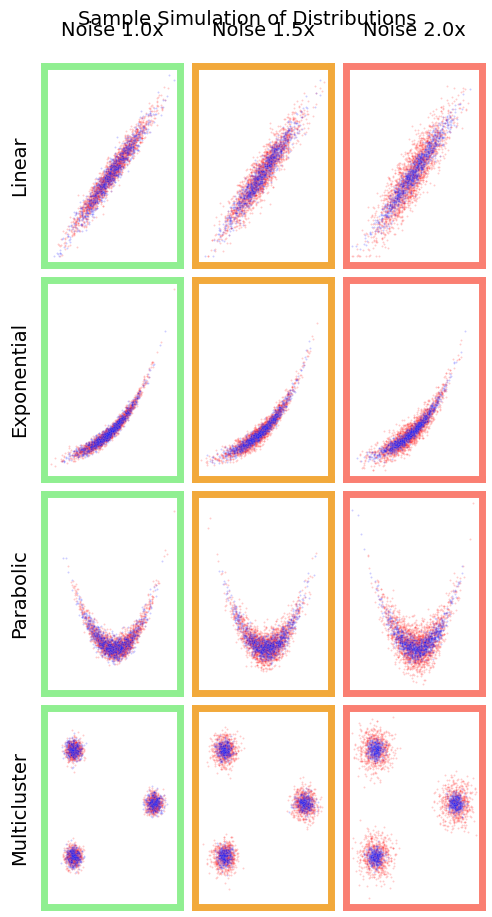

In [158]:
# Plot simulated data distributions for different data types and noise ratios
# SUPPLEMENTARY FIGURE 1
plot_simulated_data_distributions()


In [159]:
# # Uncomment the following lines to re-run simulations and save results incrementally
# # NOTE: Running the following function will overwrite existing simulation results in the output directory
# run_and_save_simulations(num_sims=10, total_batches=10)   # 10x10 simulations (100 total)

# Load previously simulated data from pickle files
path = "./data/simulations/"  # Directory containing the pickle files

# Load and combine metrics for the data types across all saved simulation batches
metrics_dfs_linear_combined = load_and_stack_metrics(path, "metrics_dfs_linear")
metrics_dfs_exp_combined = load_and_stack_metrics(path, "metrics_dfs_exp")
metrics_dfs_u_combined = load_and_stack_metrics(path, "metrics_dfs_u")
metrics_dfs_multicluster_combined = load_and_stack_metrics(path, "metrics_dfs_multicluster")

In [161]:
# # Plot metrics with error bars for each data type
# # SUPPLEMENTARY FIGURE 1
# plot_metrics_with_error_bars(metrics_dfs_linear_combined)
# plot_metrics_with_error_bars(metrics_dfs_exp_combined)
# plot_metrics_with_error_bars(metrics_dfs_u_combined)
# plot_metrics_with_error_bars(metrics_dfs_multicluster_combined)

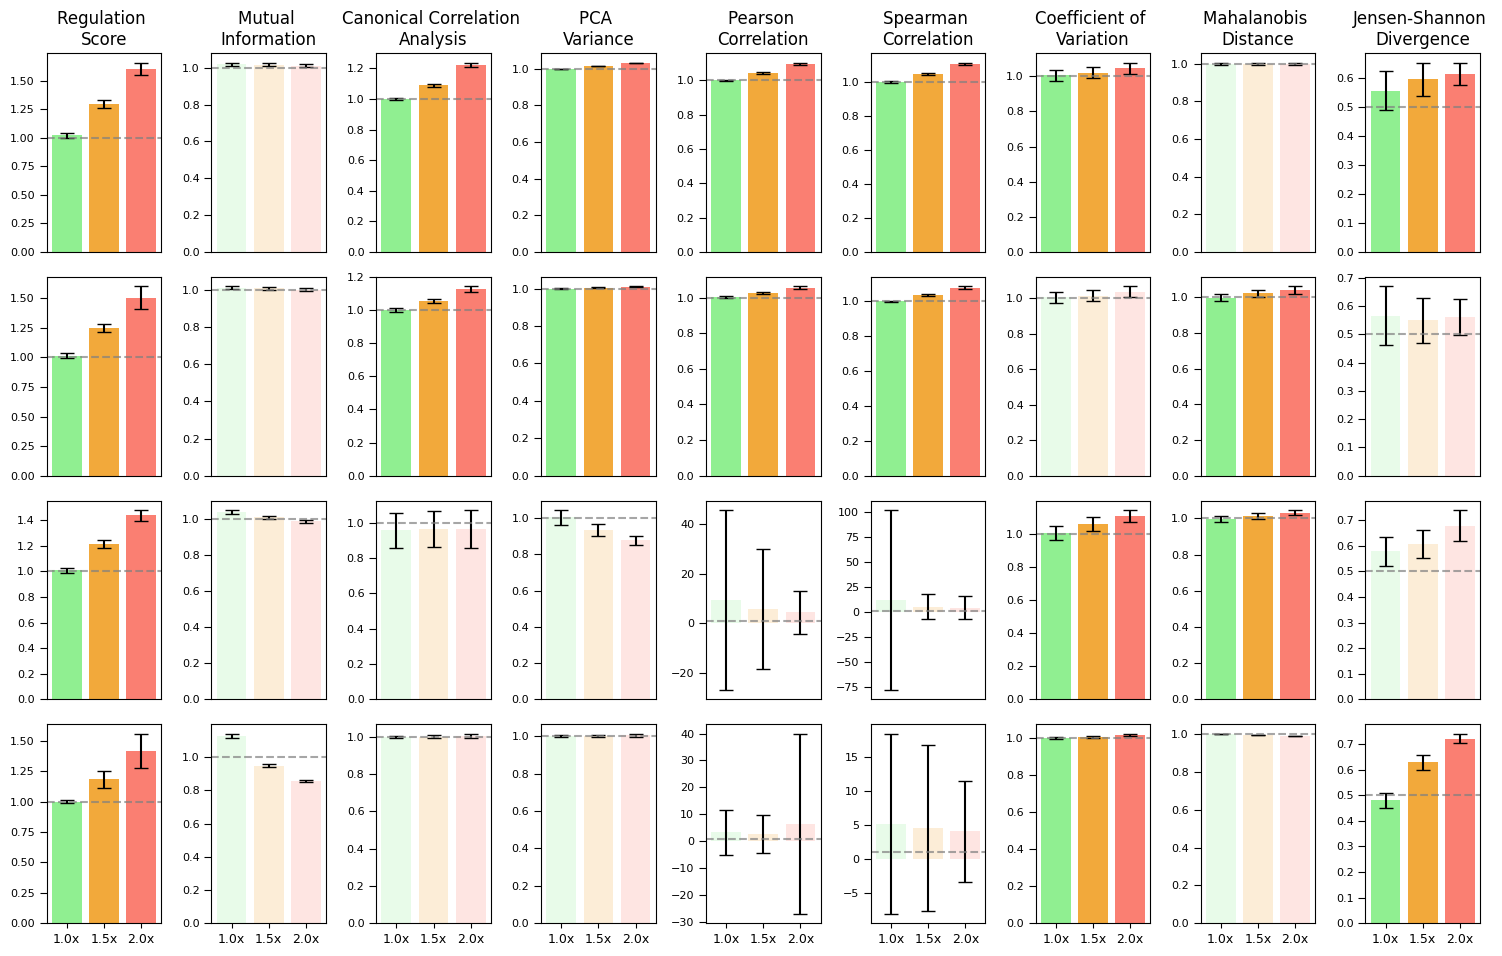

In [162]:
# Assuming metrics_combined_dict is a dictionary of metrics DataFrames
metrics_combined_dict = {
    "Linear": metrics_dfs_linear_combined,
    "Exponential": metrics_dfs_exp_combined,
    "Parabolic": metrics_dfs_u_combined,
    "Multicluster": metrics_dfs_multicluster_combined
}

plot_metrics_with_statistical_tests(metrics_combined_dict, significance_threshold=0.01)


In [163]:
# Combine the plots into a single image
save_combined_plot_without_deleting()


Combined plot saved to: ./data/figures/SupplymentaryFigure1.png


In [166]:
# Set the number of simulations for data-blind evaluation
# Set to 100 in paper
sims = 100  

# -----------------------------------------------
# Data-Blind Evaluation Explanation:
# The following simulation workflow ensures a completely data-blind evaluation:
# 1. Generate new synthetic data for each simulation run.
# 2. Calculate metrics on the generated training data.
# 3. Generate new test data independent of the training data.
# 4. Assign scores to the new test data.
# 5. Evaluate the performance (e.g., using AUROC) without the test data ever influencing the metrics.
# This ensures that the model is not overfitting or biased by prior knowledge of the test set.
# -----------------------------------------------

# # SUPPLEMENTARY FIGURE 2
# results_linear = simulate_and_evaluate(n_simulations=sims, data_type='linear', healthy_amount=1000, cancer_amount=2000, healthy_noise=0.1, noise_ratio=3.5,save_path ='./data/figures/SupplymentaryFigure2_Part1.png')
# results_exp = simulate_and_evaluate(n_simulations=sims, data_type='exp', healthy_amount=1000, cancer_amount=2000, healthy_noise=0.09, noise_ratio=3.5,save_path = './data/figures/SupplymentaryFigure2_Part2.png')
# results_u = simulate_and_evaluate(n_simulations=sims, data_type='u', healthy_amount=1000, cancer_amount=2000, healthy_noise=0.05, noise_ratio=3.5,save_path = './data/figures/SupplymentaryFigure2_Part3.png')
# results_multicluster = simulate_and_evaluate(n_simulations=sims, data_type='multicluster', healthy_amount=1000, cancer_amount=2000, healthy_noise=0.03, noise_ratio=3.5,save_path = './data/figures/SupplymentaryFigure2_Part4.png')

In [168]:
# SUPPLEMENTARY FIGURE 2
# Combine the plots into a single image
save_combined_suppfigure2_plot()


Combined plot saved to: ./data/figures/SupplymentaryFigure2.png
